# Area of Interest Definition and Product Download
## Area of Interest

In contrast to the explorations of previous chapters which looked at larger areas of interest, this section aims to harness the high resolution of Sentinel-2 data to provide highly localized information.

The area of interest is the Tempelhofer feld, a park area in Berlin, whose geometry can be queried from the OpenStreetMap Nominatim API.

In [1]:
from pathlib import Path
from sentinel_helpers import search_osm

tempelhofer_feld = search_osm('Tempelhofer Feld, Berlin, Germany').iloc[:1]

Because smaller areas like this are not often plotted on maps using well-defined borders, verifying the obtained geometry can be hard to do by looking only at their silhouette.

The `folium` library supports creating interactive map widgets where shapes can be placed on a background layer. This background layer is also created from OpenStreetMap-data and provides a styled representation of additional information such as buildings and streets.

The `sentinel_helpers` module contains a function which wraps a call to the `folium.Map` constructor so that different kinds of `geopandas`-based geometries can be displayed with a single function call:

In [2]:
from sentinel_helpers import geodataframe_on_map
??geodataframe_on_map

Signature: geodataframe_on_map(geodataframe)
Source:   
def geodataframe_on_map(geodataframe):
    '''
    Plot a GeoDataframe or GeoSeries on a Leaflet map; map automatically
    centers
    '''
    bbox = geodataframe.unary_union.bounds
    minx, miny, maxx, maxy = bbox
    m = folium.Map([0, 0], tiles='cartodbpositron', scroll_wheel_zoom=False)
    folium.GeoJson(geodataframe.to_json()).add_to(m)
    m.fit_bounds([[miny, minx], [maxy, maxx]])
    return m
File:      ~/sources/sentinel_helpers.py
Type:      function


In [3]:
geodataframe_on_map(tempelhofer_feld)

The shape correctly represents the Tempelhofer Feld, excluding the area of the former airport building. It encompasses an area which is mostly covered by grass and permeated with tarred footways, which were formerly used as runways.

### Open Access Hub Query

The Open Access Hub is queried for an entire year of products covering the Tempelhofer Feld, excluding those with a cloud coverage of over 30%.

In [4]:
from datetime import date
from sentinelsat import SentinelAPI
from shapely.geometry import box
from tqdm.notebook import tqdm
import os

# save area of interest as GeoJSON
base_path = Path('resources/tempelhofer_feld')
base_path.mkdir(exist_ok=True, parents=True)
tempelhofer_feld.to_file(base_path / 'tempelhofer_feld.geojson', driver='GeoJSON')

# construct api client
api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))
api._tqdm = tqdm # nicer progress bars

# send query
footprint = tempelhofer_feld.convex_hull.iloc[0]
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(date(2019,1,1), date(2019,12,31)),
                     cloudcoverpercentage=(0,30))

print(f'Found {len(products)} products')

Found 77 products


To avoid the the merging process demonstrated in [](01d-true color-mosaic), only products that fully contain the Tempelhofer Feld are considered.
The footprints (i.e. the geometries) of the returned products are therefore intersected with the Tempelhofer Feld geometry using the `geopandas` library:

In [5]:
import geopandas as gpd

products_gdf = api.to_geodataframe(products)
intersected = gpd.overlay(products_gdf.to_crs('EPSG:4326'), tempelhofer_feld.to_crs('EPSG:4326'), how='intersection')
len(intersected)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


77

In [6]:
intersected.geometry.unique()

<GeometryArray>
Length: 1, dtype: geometry

The intersection returned 77 geometries, all of which consist of an identically shaped polygon.
The Tempelhofer Feld is therefore fully contained in all search results.

Berlin is located close to the edge of the tiling grid which is used by the Copernicus Open Access Hub to separate different products. There is overlap between the tiles, which means that multiple products at the same point in time contain identical data on their edges.
The files to download is reduced by keeping only the first captured product for a particular capture date.
All of the remaining products are plotted on top of the area of interest for a final visual confirmation.

<AxesSubplot:title={'center':'Area of Interest and Available Products'}>

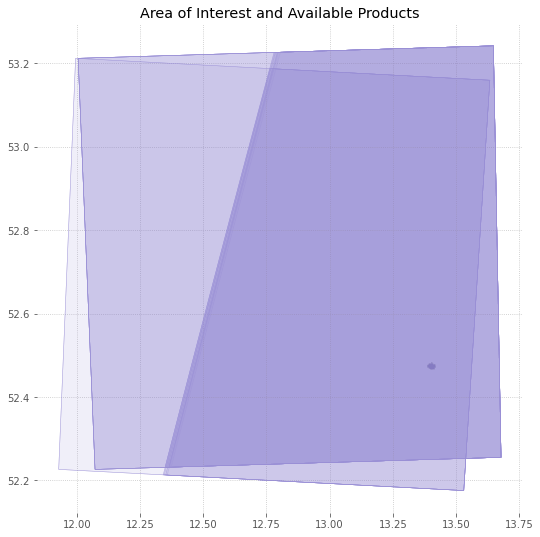

In [7]:
from sentinel_helpers import plot_product_extent

deduped = products_gdf.drop_duplicates(subset='beginposition', keep='first')
plot_product_extent(deduped, tempelhofer_feld, figsize=(9,9), alpha=0.05)

The Tempelhofer Feld is the dark spot towards the bottom right area of the plot.

The spectral index is to be calculated over a long time span. This is only possible if there is enough data consistently available over over a long time frame.

The query has been restricted by a low acceptable cloud coverage, so product availability should be lower in the generally more cloudy winter months:

<AxesSubplot:xlabel='week'>

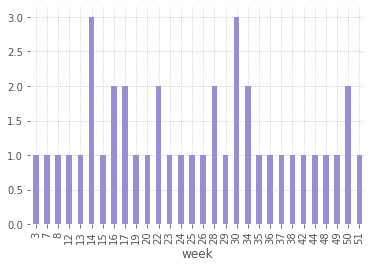

In [8]:
captured_at = deduped['beginposition'].astype('datetime64')
captured_at.groupby(captured_at.dt.isocalendar().week).count().plot(kind='bar')

Product availability is, as expected, lower during the beginning of the year, with several weeks worth of data missing. There is also no data for week 21 and between weeks 30 and 34, but in total data is available for 30 different weeks. This is more than every other week of the year, which is a very high frequency for a small area which no team was explicitly assigned to collect data for.

### Data Retrieval

The products are downloaded from the Copernicus Open Access Hub.

In [ ]:
api.download_all(deduped['uuid'].values, directory_path=base_path)